In [23]:
%load_ext autoreload
%autoreload 2
from utils_dir import get_curr_dir, include_home_dir
include_home_dir()

import pandas as pd

from jumpmodels.utils import filter_date_range        # useful helpers
from jumpmodels.jump import JumpModel                 # class of JM & CJM
from jumpmodels.sparse_jump import SparseJumpModel    # class of Sparse JM

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data & Features

This example demonstrates the class of *statistical jump models* (JMs) and various helper functions for regime analysis provided by our package `jumpmodels`, using an application on the Nasdaq-100 Index. 
The core classes, `JumpModel` and `SparseJumpModel`, implement the original JM, continuous JM (CJM), and sparse JM (SJM) with feature selection.
These models follow the API style used in `scikit-learn` for easy integration and efficient usage.
For detailed mathematical and algorithmic explanations of these models, please refer to the literature cited in the `README`.

Relevant helper functions will be imported as needed throughout this example.
If running this notebook in Jupyter Lab/Notebook poses any issues, there is an exported `.py` script available in this folder for convenient execution.


## Raw Data

In the original example, data used was from a pickle file in the repo. In this fork, I moved the data retrieval code into this notebook for convenience. I kept the explanation from the original example below.

### Explanation from the original example
In this example, we analyze the regimes of the Nasdaq-100 Index.
The daily index price data is retrieved from [Yahoo Finance](https://finance.yahoo.com/quote/%5ENDX/) under the ticker `NDX`. 

The data retrieval is handled in the script `get_data.py`, and the dataset is already saved in the `example/Nasdaq/data/` folder in both `csv` and `pkl` formats, so there’s no need to run `get_data.py` manually.

We work with daily frequency data using `pandas` DataFrames, where the index is of type `datetime.date`. 
This format is consistent with the convention used in the `CRSP` database. 
All helper functions in this package are designed to support this type of date index.

In [24]:
# set the ticker and date ranges in this code block.
import datetime

# NOTE: carets need to be escaped when passing to matplotlib for latex (e.g., `r"\^NDX"`), because they are
# special characters for the math mode. Below is a temporary solution.
DISPLAY_TICKER = "NDX"
YFINANCE_TICKER = DISPLAY_TICKER
# YFINANCE_TICKER = f"^{DISPLAY_TICKER}"

DATA_START_DATE = "1985-10-01"
DATA_END_DATE = datetime.date.today()

# NOTE: `TRAINING_START_DATE` needs to be later than the `DATA_START_DATE`
# to get percentage difference on the first training date
TRAINING_START_DATE = "2007-1-1"
TRAINING_END_DATE = "2022-1-1"


In [25]:
# `get_data.py` content is transferred here, without the redundant imports

import numpy as np
import yfinance as yf

from jumpmodels.utils import check_dir_exist

# download closing prices
close: pd.Series = yf.download(YFINANCE_TICKER, start=DATA_START_DATE, end=DATA_END_DATE)['Close']
# convert to ret
ret = close.pct_change()
# concat as df
df = pd.DataFrame({"close": close.squeeze(), "ret": ret.squeeze()}, index=close.index.date)
df.index.name = "date"

# save
curr_dir = get_curr_dir()
data_dir = f"{curr_dir}/data/"; check_dir_exist(data_dir)
pd.to_pickle(df, f"{data_dir}{DISPLAY_TICKER}.pkl")
np.round(df, 6).to_csv(f"{data_dir}{DISPLAY_TICKER}.csv")
print("Successfully downloaded data for ticker:", DISPLAY_TICKER)


[*********************100%***********************]  1 of 1 completed

Successfully downloaded data for ticker: SPY


## Feature Engineering

Feeding the model a robust feature set is key to the successful application of any learning algorithm. 
This example uses a simple feature set consisting of nine features: the exponentially weighted moving (EWM) return, downside deviation (in log scale), and Sortino ratio, each computed with three halflife values ranging from one week (5 days) to one quarter (3 months). 

Users may need to adjust the features or halflives to suit their specific applications. 
The literature referenced in the `README` offers a solid foundation for further exploration.

The computation of these features is detailed in `feature.py` in the same folder as this example, and we use the `DataLoader` class to load both the index returns and the engineered features.
The loaded data covers the period from the start of 2007 to the end of September 2024.

In [26]:
from feature import DataLoader

data = DataLoader(ticker=DISPLAY_TICKER, ver="v0").load(start_date=DATA_START_DATE, end_date=DATA_END_DATE)

print("Daily returns stored in `data.ret_ser`:", "-"*50, sep="\n")
print(data.ret_ser, "-"*50, sep="\n")
print("Features stored in `data.X`:", "-"*50, sep="\n")
print(data.X)

Daily returns stored in `data.ret_ser`:
--------------------------------------------------
date
1993-02-01    0.007112
1993-02-02    0.002119
1993-02-03    0.010571
1993-02-04    0.004184
1993-02-05   -0.000695
                ...   
2024-12-23    0.005988
2024-12-24    0.011115
2024-12-26    0.000067
2024-12-27   -0.010527
2024-12-30   -0.011412
Name: SPY, Length: 8036, dtype: float64
--------------------------------------------------
Features stored in `data.X`:
--------------------------------------------------
               ret_5  DD-log_5  sortino_5    ret_20  DD-log_20  sortino_20    ret_60  DD-log_60  sortino_60
date                                                                                                       
1993-02-01  0.007112      -inf        inf  0.007112       -inf         inf  0.007112       -inf         inf
1993-02-02  0.004443      -inf        inf  0.004572       -inf         inf  0.004601       -inf         inf
1993-02-03  0.006774      -inf        inf  0.006

## Train/Test Split and Preprocessing

We perform a simple time-based split: data from the beginning of 2007 to the end of 2021, covering a 15-year period, is used as the training set for fitting the JMs.
The period from 2022 to late 2024 is reserved as the test set, where we apply the trained JMs to perform online regime inference.
We use the helper function `filter_date_range` to filter the start and end dates of a DataFrame.

In [27]:
train_start, test_start = TRAINING_START_DATE, TRAINING_END_DATE
# filter dates
X_train = filter_date_range(data.X, start_date=train_start, end_date=test_start)
X_test = filter_date_range(data.X, start_date=test_start)
# print time split
train_start, train_end = X_train.index[[0, -1]]
test_start, test_end = X_test.index[[0, -1]]
print("Training starts at:", train_start, "and ends at:", train_end)
print("Testing starts at:", test_start, "and ends at:", test_end)

Training starts at: 2007-01-03 and ends at: 2021-12-31
Testing starts at: 2022-01-03 and ends at: 2024-12-30


The module `jumpmodels.preprocess` provides two classes for preprocessing: one for standardizing and one for clipping the feature data. 
We first clip the data within three standard deviations for all features and then perform standardization before feeding the data into the JMs. 
Both classes are first fitted on the training data and subsequently used to transform the test data.

These classes support both `pandas` DataFrames and `numpy` arrays as direct inputs and outputs. 
We prefer to retain the DataFrame type whenever possible to preserve the date index and column labels.

In [28]:
# Preprocessing
from jumpmodels.preprocess import StandardScalerPD, DataClipperStd
clipper = DataClipperStd(mul=3.)
scalar = StandardScalerPD()
# fit on training data
X_train_processed = scalar.fit_transform(clipper.fit_transform(X_train))
# transform the test data
X_test_processed = scalar.transform(clipper.transform(X_test))

# Original JM

## In-Sample Fitting

We begin by illustrating the in-sample training of the original JM.
The model parameters are set as follows: the number of components/states/regimes is 2, the jump penalty $\lambda$ is 50.0, and `cont=False`, indicating the original discrete JM that performs hard clustering. 
It is important to note that the jump penalty $\lambda$ is a crucial hyperparameter that requires tuning, either through statistical criteria or cross-validation (see references for details). 

The docstring provides comprehensive documentation of all parameters and attributes (thanks to ChatGPT).

In [29]:
# set the jump penalty
jump_penalty=50.
# initlalize the JM instance
jm = JumpModel(n_components=2, jump_penalty=jump_penalty, cont=False, )

In the `.fit()` call, we pass the return series for each period to be used for sorting the states.
We specify `sort_by="cumret"`, meaning that the state labels (0 or 1) are determined by the cumulative returns under each state. The state with higher cumulative returns is denoted as $s_t=0$ (bull market), and the state with lower returns is denoted as $s_t=1$ (bear market). 


In [30]:
# call .fit()
jm.fit(X_train_processed, data.ret_ser, sort_by="cumret")

JumpModel(jump_penalty=50.0)

The cluster centroids for each state are stored in the `centers_` attribute. 
While these values are scaled, making direct interpretation hard, the bull market state is clearly characterized by higher returns, lower downside deviation, and a higher Sortino ratio, with a distinct separation between the two regimes.

In [31]:
print("Scaled Cluster Centroids:", pd.DataFrame(jm.centers_, index=["Bull", "Bear"], columns=X_train.columns), sep="\n" + "-"*50 + "\n")

Scaled Cluster Centroids:
--------------------------------------------------
         ret_5  DD-log_5  sortino_5    ret_20  DD-log_20  sortino_20    ret_60  DD-log_60  sortino_60
Bull  0.149161 -0.363552   0.183718  0.311888  -0.378659    0.316966  0.410510  -0.307675    0.405746
Bear -0.492503  1.200386  -0.606603 -1.029800   1.250266   -1.046565 -1.355433   1.015887   -1.339702


### Visualization

The `jumpmodels.plot` module provides useful functions for visualizing regime identification. 
We'll use the `labels_` attribute of the JM instance, which contains integers from 0 to `n_c-1`, representing the in-sample fitted regime assignment for each period.

From the plot, we observe that the identified regimes for the Nasdaq-100 Index successfully capture several significant market downturns, including the global financial crisis, corrections in 2012, 2015-2016, 2019, and the COVID-19 crash in 2020. 
These identified regimes correspond well to shifts in market fundamentals, as interpreted in hindsight.


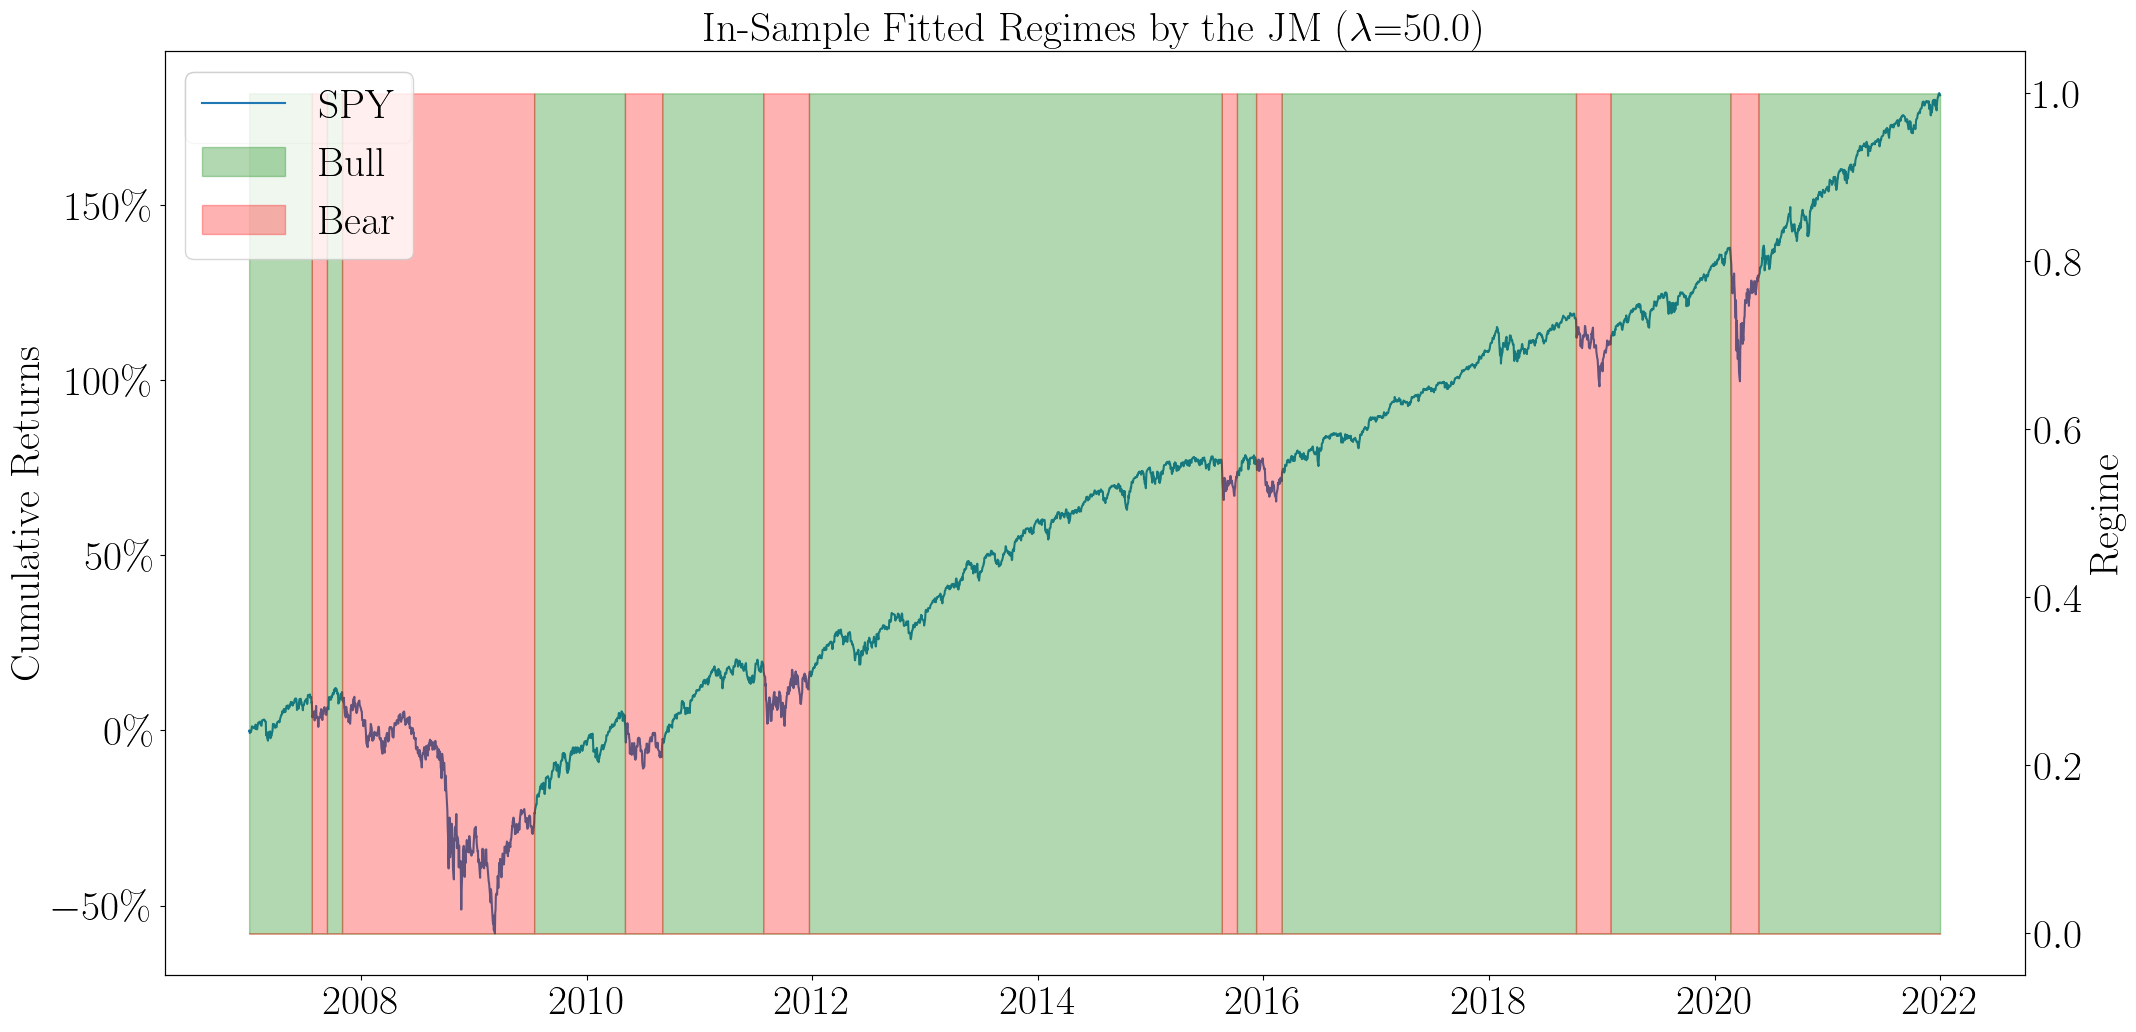

In [32]:
from jumpmodels.plot import plot_regimes_and_cumret, savefig_plt

ax, ax2 = plot_regimes_and_cumret(jm.labels_, data.ret_ser, n_c=2, start_date=train_start, end_date=train_end, )
ax.set(title=f"In-Sample Fitted Regimes by the JM ($\\lambda$={jump_penalty})")
savefig_plt(f"{get_curr_dir()}/plots/JM_lambd-{jump_penalty}_train.pdf")

### Modifying Parameters via `set_params()`

Our model inherits from the `BaseEstimator` class provided by `scikit-learn`, enabling a wide range of utility methods.
Among these, we highlight the `.set_params()` function, which allows users to reset any input parameters without creating a new instance.
This functionality is particularly useful when the model needs to be refitted multiple times, such as when testing different jump penalties.

As an example, we reset the jump penalty to zero, effectively reducing the model to a baseline $k$-means clustering algorithm where temporal information is ignored. 
This comparison illustrates the value of applying a jump penalty to ensure temporal consistency and reduce the occurrence of unrealistic regime shifts.

In [33]:
# reset jump_penalty to zero
jump_penalty=0.
jm.set_params(jump_penalty=jump_penalty)
print("The jump penalty of the JM instance has been reset to: jm.jump_penalty =", jm.jump_penalty)

The jump penalty of the JM instance has been reset to: jm.jump_penalty = 0.0


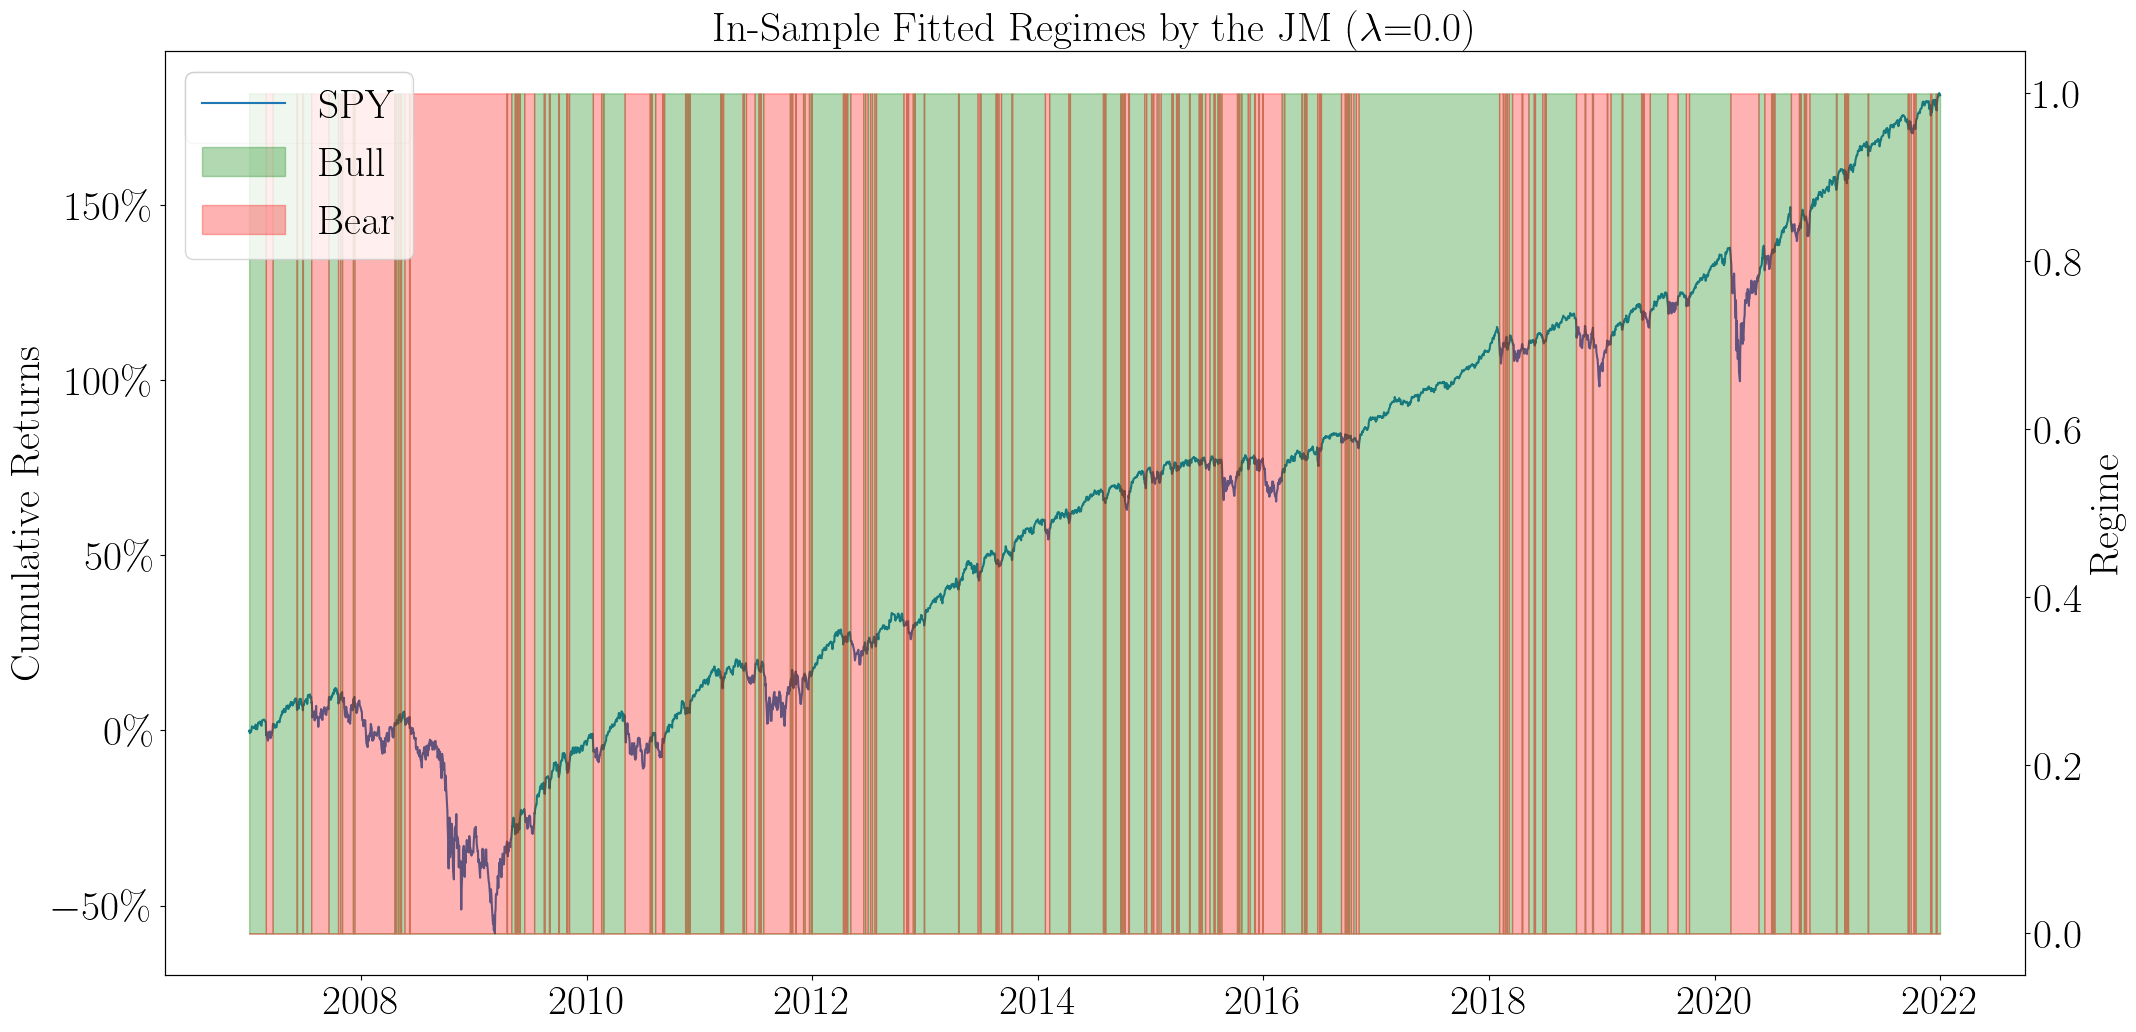

In [34]:
# refit
jm.fit(X_train_processed, data.ret_ser, sort_by="cumret")

# plot
ax, ax2 = plot_regimes_and_cumret(jm.labels_, data.ret_ser, n_c=2, start_date=train_start, end_date=train_end, )
ax.set(title=f"In-Sample Fitted Regimes by the JM ($\\lambda$={jump_penalty})")
savefig_plt(f"{get_curr_dir()}/plots/JM_lambd-{jump_penalty}_train.pdf")

## Online Inference

After completing the in-sample training, we apply the trained models for online inference on the test period using the `predict_online()` method. 
Here, *online inference* means that the regime inference for period $t$ is based solely on the data available up to the end of that period, without using any future data.
We revert the jump penalty to a reasonable value of 50.0.



In [35]:
# refit
jump_penalty=50.
jm.set_params(jump_penalty=jump_penalty).fit(X_train_processed, data.ret_ser, sort_by="cumret")
# make online inference 
labels_test_online = jm.predict_online(X_test_processed)

From the visualization below, we observe that the JM effectively signals the bear market in 2022, driven by aggressive interest rate hikes. 
This period saw a return of over $-$15% and a significant drawdown.
However, the brief bear period captured in the second half of 2024 is followed by a strong price reversal.
This latency issue constitutes a common challenge in real-time applications of regime-switching signals.
Improving the feature set or fine-tuning the jump penalty may help address this issue.

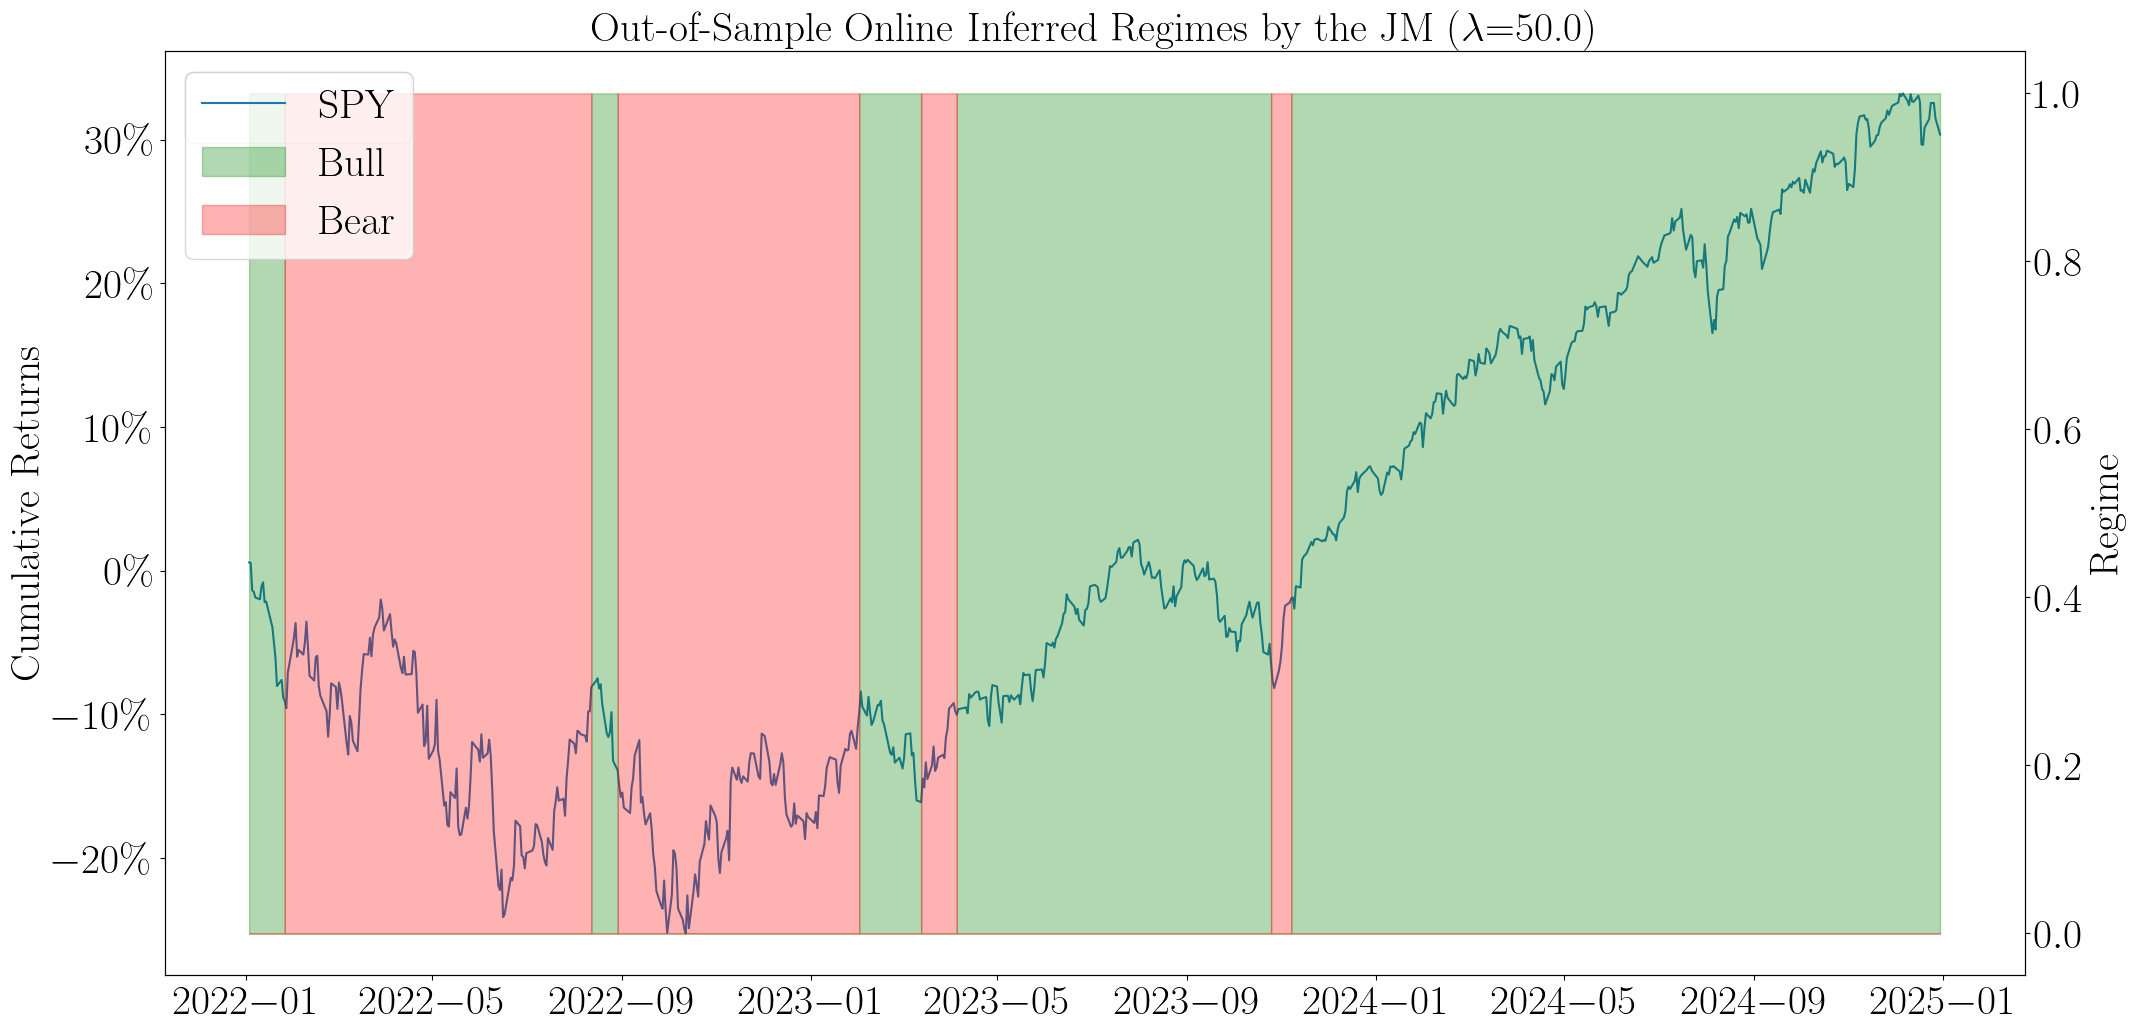

In [36]:
# plot and save
ax, ax2 = plot_regimes_and_cumret(labels_test_online, data.ret_ser, n_c=2, start_date=test_start, end_date=test_end, )
ax.set(title=f"Out-of-Sample Online Inferred Regimes by the JM ($\\lambda$={jump_penalty})")
savefig_plt(f"{get_curr_dir()}/plots/JM_lambd-{jump_penalty}_test_online.pdf")

In contrast to online inference, the `.predict()` method performs state decoding using all test data (i.e., from 2022 to 2024) at once. 
While this approach is less realistic for trading applications, we observe that, with access to the full dataset, the model avoids the reversal in late 2024 and exits the bear signal in 2023 slightly earlier than with online inference.

Though this approach is less applicable for real-world backtesting in financial markets, it holds potential uses in other engineering fields (such as language modeling, where access to an entire sentence is available at once.)

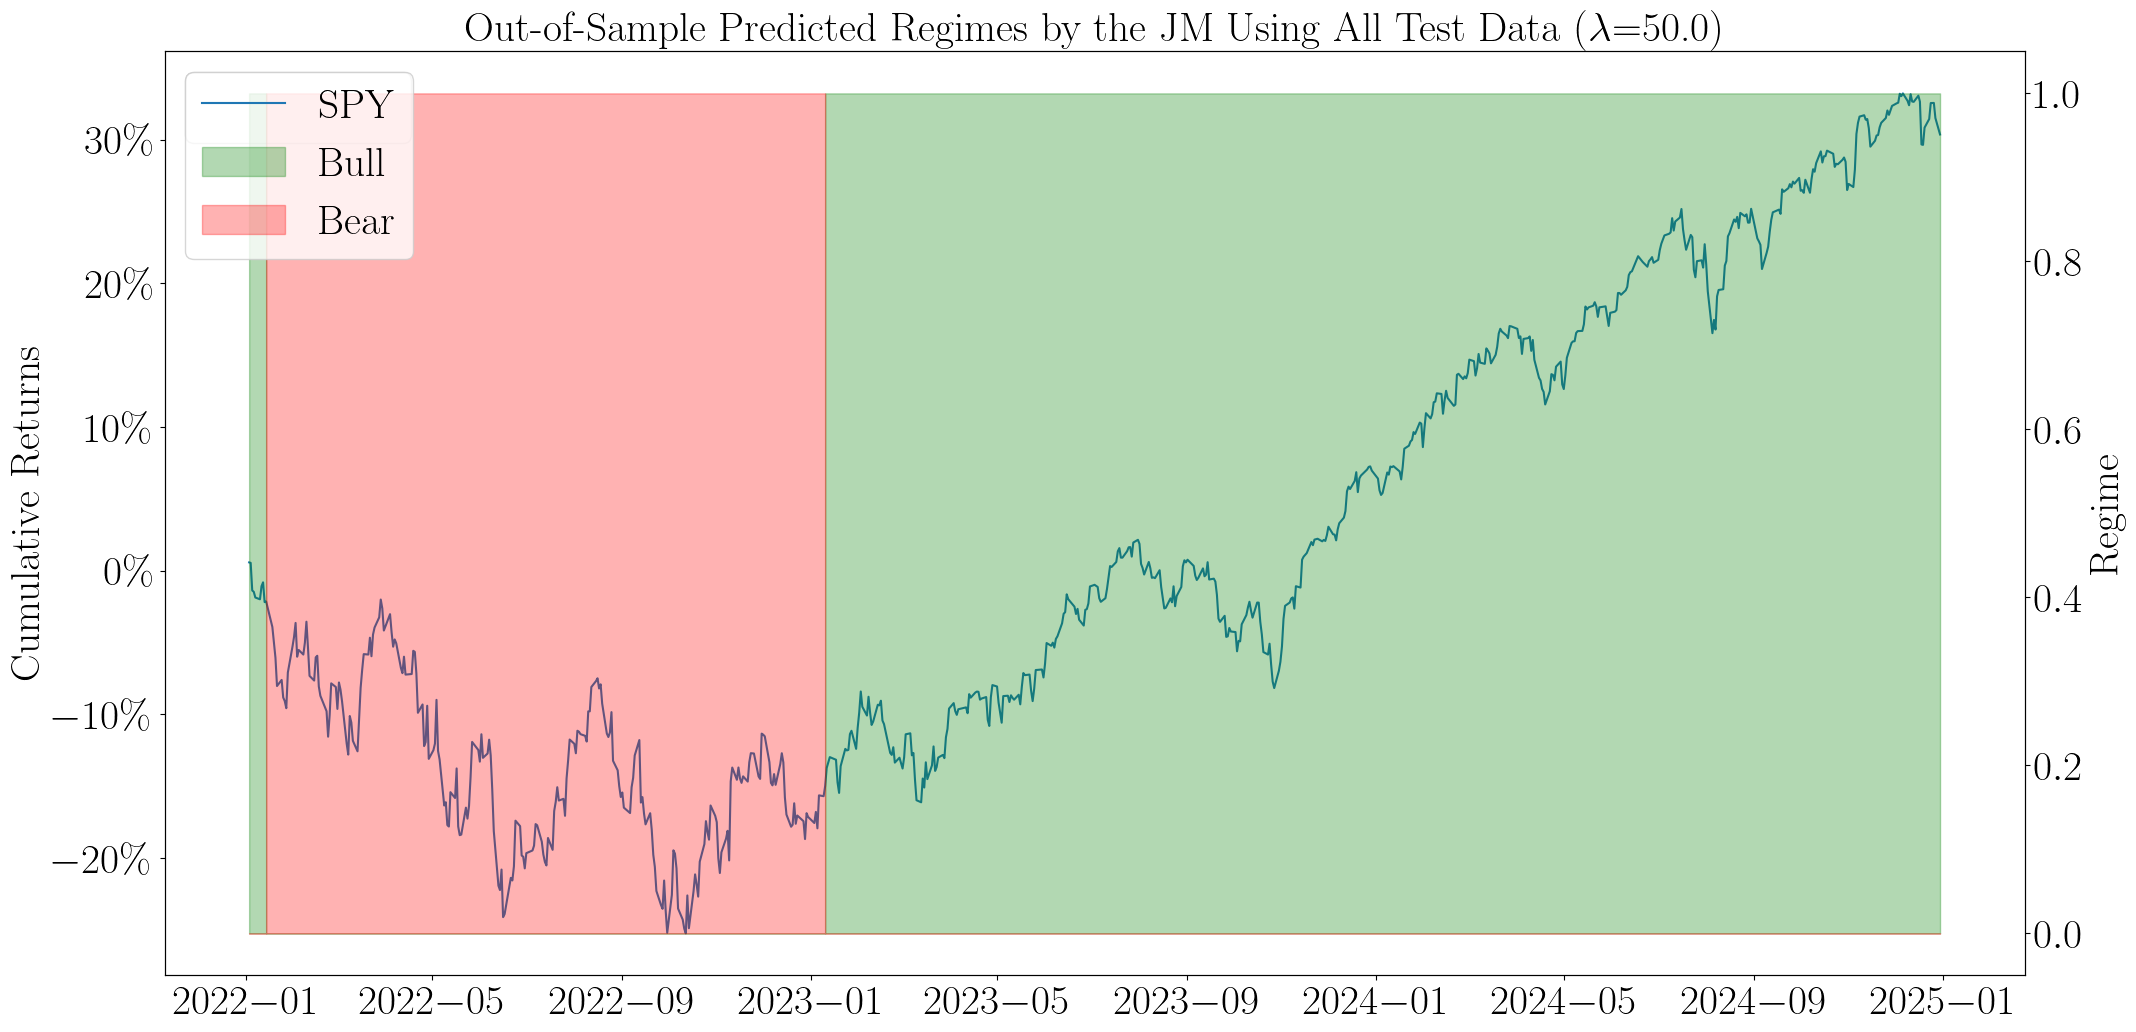

In [37]:
# make inference using all test data
labels_test = jm.predict(X_test_processed)
# plot
ax, ax2 = plot_regimes_and_cumret(labels_test, data.ret_ser, n_c=2, start_date=test_start, end_date=test_end, )
_ = ax.set(title=f"Out-of-Sample Predicted Regimes by the JM Using All Test Data ($\\lambda$={jump_penalty})")

# CJM: Continuous Extension of the JM

With this, we conclude a minimal overview of the core functionality of using JMs to assign regime labels to in-sample training periods and leverage trained models for out-of-sample prediction, either through online inference or by processing all data at once. 
The methods -- such as `.fit()`, `.set_params()`, and `predict_online()` -- extend seamlessly to the following JM variants: CJM and SJM. 
Here, we provide brief illustrations of these extensions.

## In-Sample Fitting

The CJM (Continuous Jump Model) uses the same `JumpModel` class as the discrete model, with the parameter `cont=True`. 

### Parameters 

Regarding the jump penalty value, it is typically set to be 10 times larger than the $\lambda$ used in the discrete model to achieve similar fittings, so we choose $\lambda=600.0$ here.

Additionally, CJM introduces two specialized parameters: `mode_loss` and `grid_size`, which require more nuanced understanding. 
Generally, the default values are recommended for most cases.


In [38]:
jump_penalty=600.
cjm = JumpModel(n_components=2, jump_penalty=jump_penalty, cont=True)

The `proba_` attribute of the CJM instance stores the estimated probability of each period belonging to each state.
Unlike the discrete model, where the state assignment changes abruptly, CJM offers smooth probability transitions, ranging from 0% to 100%. 
This probabilistic interpretation has potential applications in many domains, especially where softer regime assignments are beneficial.

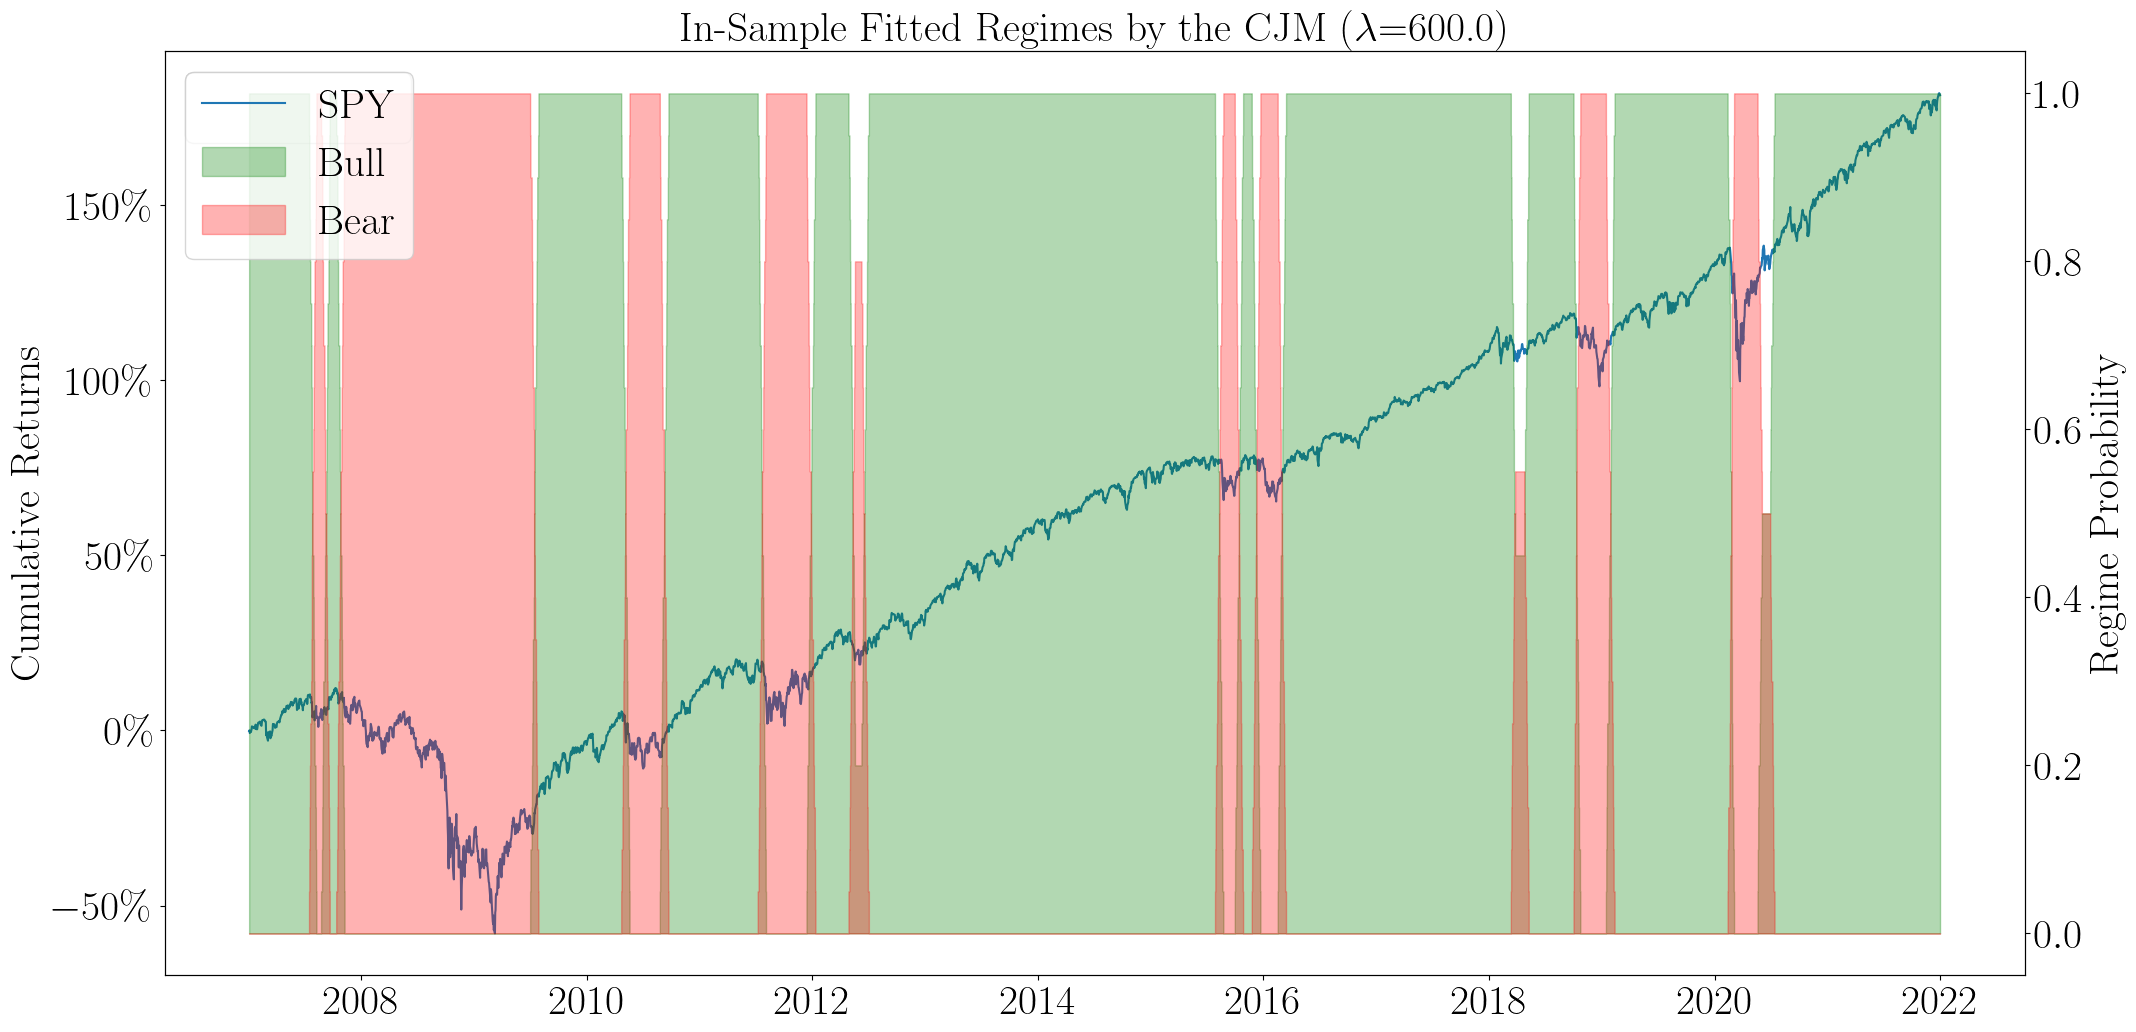

In [39]:
cjm.fit(X_train_processed, data.ret_ser, sort_by="cumret")

# plot
ax, ax2 = plot_regimes_and_cumret(cjm.proba_, data.ret_ser, n_c=2, start_date=train_start, end_date=train_end, )
ax2.set(ylabel="Regime Probability")
ax.set(title=f"In-Sample Fitted Regimes by the CJM ($\\lambda$={jump_penalty})")
savefig_plt(f"{get_curr_dir()}/plots/CJM_lambd-{jump_penalty}_train.pdf")

## Online Inference

The `.predict_proba_online()` method allows CJM to make probabilistic regime inferences online.
From the plot, we observe that the confidence in the bear market during late 2024 doesn't fully reach 100%, potentially reducing the mislabeling issue discussed earlier. 
This smoother transition in probabilities may offer better regime detection in uncertain market conditions.

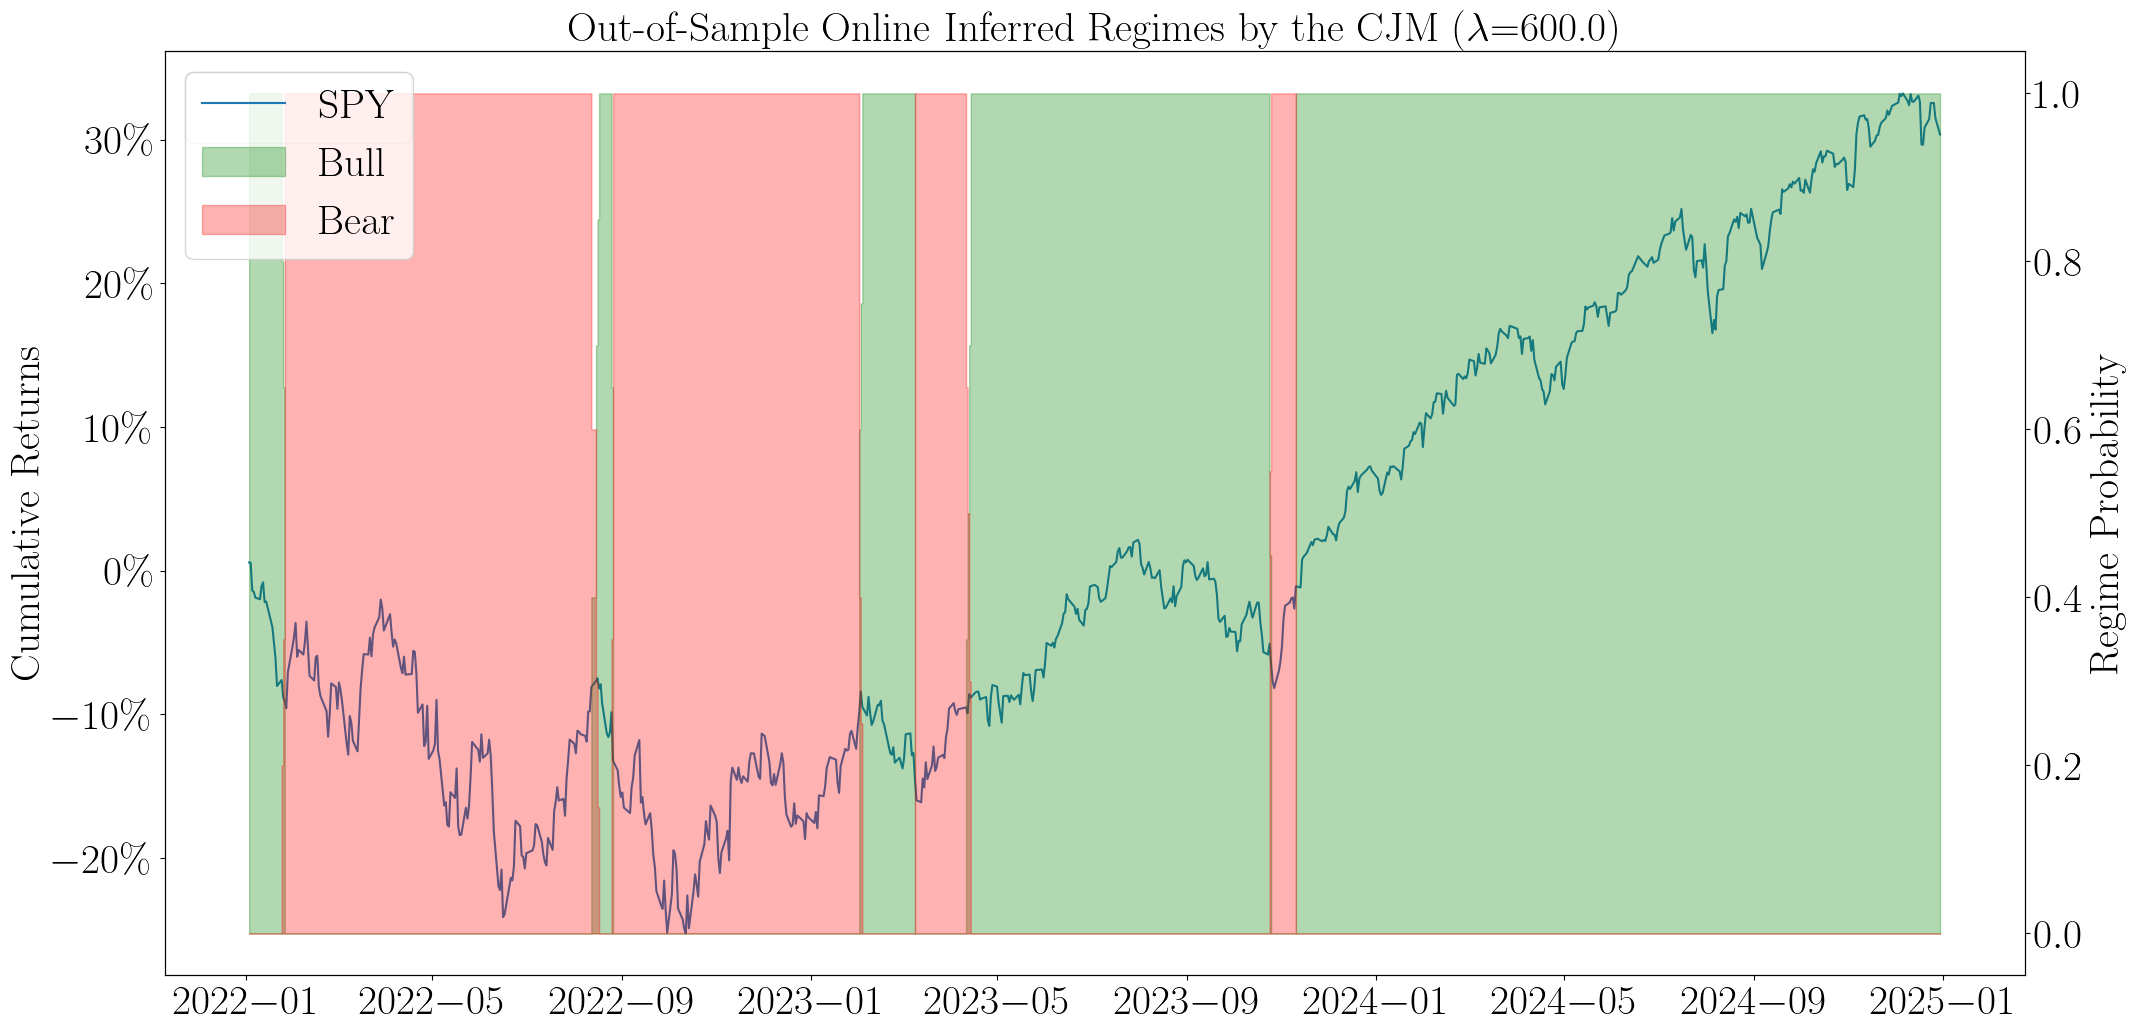

In [40]:
# online inference
proba_test_online = cjm.predict_proba_online(X_test_processed)

# plot
ax, ax2 = plot_regimes_and_cumret(proba_test_online, data.ret_ser, start_date=test_start, end_date=test_end, )
ax2.set(ylabel="Regime Probability")
ax.set(title=f"Out-of-Sample Online Inferred Regimes by the CJM ($\\lambda$={jump_penalty})")
savefig_plt(f"{get_curr_dir()}/plots/CJM_lambd-{jump_penalty}_test_online.pdf")

# SJM: Sparse JM with Feature Selection

Finally, the Sparse Jump Model (SJM) introduces feature weighting on top of the original JM or CJM. 
Features leading to better in-sample clustering effects, as measured by variance reduction, are assigned higher weights, while a LASSO-like constraint on the weight vector ensures that noisy features receive zero weight.

## In-Sample Fitting

### Parameters

SJM is implemented in the class `SparseJumpModel`, with an additional parameter `max_feats`, which controls the number of features included.
This parameter roughly reflects the effective number of features. (In the notation of Nystrup et al. (2021), `max_feats` corresponds to $\kappa^2$.)

The jump penalty value is of a similar magnitude to the non-sparse model. In this case, we try `max_feats=3.` and `jump_penalty=50.`

In [41]:
max_feats=3.
jump_penalty=50.
# init sjm instance
sjm = SparseJumpModel(n_components=2, max_feats=max_feats, jump_penalty=jump_penalty, )
# fit
sjm.fit(X_train_processed, ret_ser=data.ret_ser, sort_by="cumret")

SparseJumpModel(jump_penalty=50.0, max_feats=3.0)

The feature weights are stored in the attribute `feature_weights`. 
Generally, we observe that features with longer halflives receive higher weights, indicating that less smoothed features are noisier and are excluded from the model, thanks to the feature weighting mechanism.

In [42]:
print("SJM Feature Weights:", "-"*50, sjm.feat_weights, sep="\n")

SJM Feature Weights:
--------------------------------------------------
ret_5         0.000000
DD-log_5      0.249601
sortino_5     0.000000
ret_20        0.000000
DD-log_20     0.588494
sortino_20    0.000000
ret_60        0.822636
DD-log_60     0.000000
sortino_60    0.804173
dtype: float64


A comparison of the SJM-identified regimes with those identified by JM reveals that the GFC is consolidated into a single bear regime, demonstrating that short-term noise has been effectively mitigated.

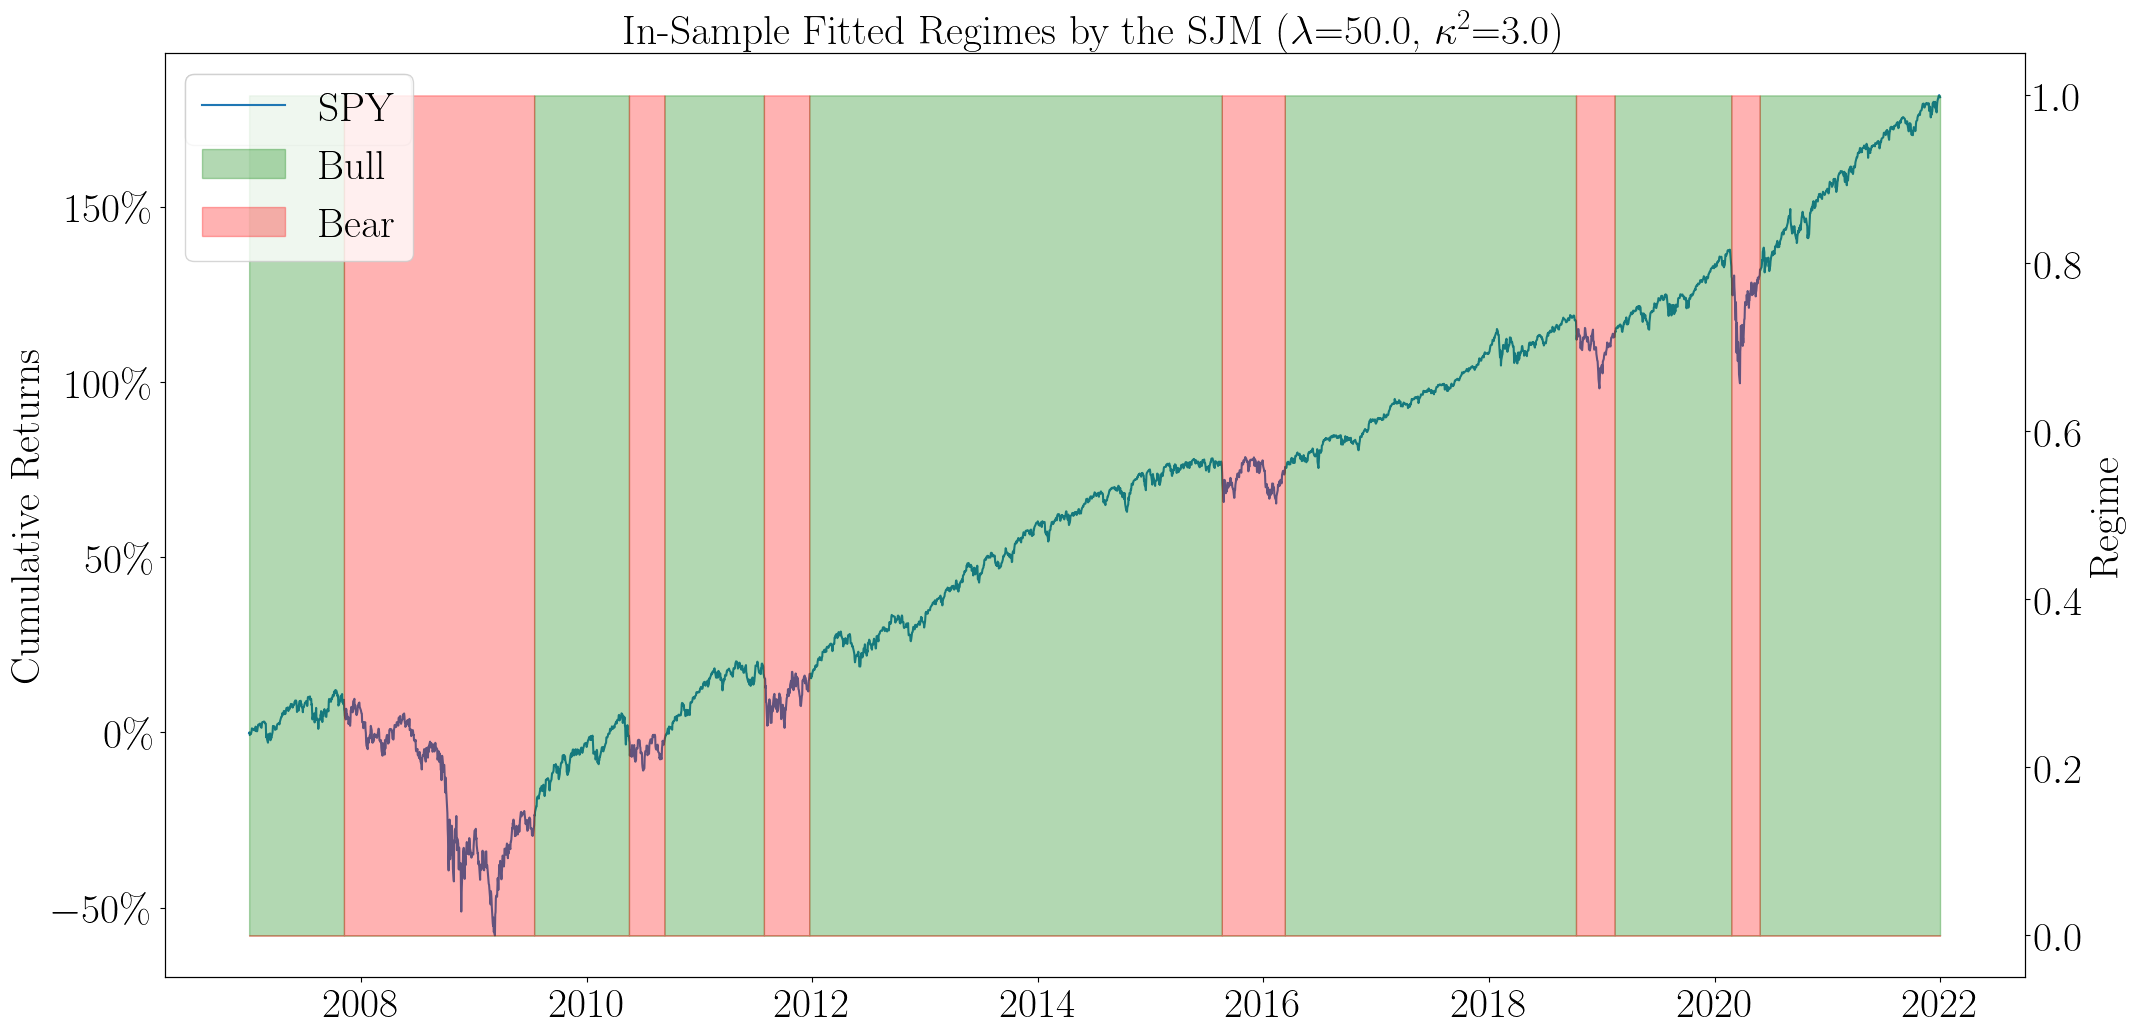

In [43]:
# plot
ax, ax2 = plot_regimes_and_cumret(sjm.labels_, data.ret_ser, n_c=2, start_date=train_start, end_date=train_end, )
ax.set(title=f"In-Sample Fitted Regimes by the SJM ($\\lambda$={jump_penalty}, $\\kappa^2$={max_feats})")
savefig_plt(f"{get_curr_dir()}/plots/SJM_lambd-{jump_penalty}_max-feats-{max_feats}_train.pdf")

## Online Inference

As before, the `.predict_online()` method handles online inference. 
Notably, through feature selection, the previously problematic bear market signal in late 2024 is absent in the SJM's online inference, highlighting the potential benefits of feature selection.



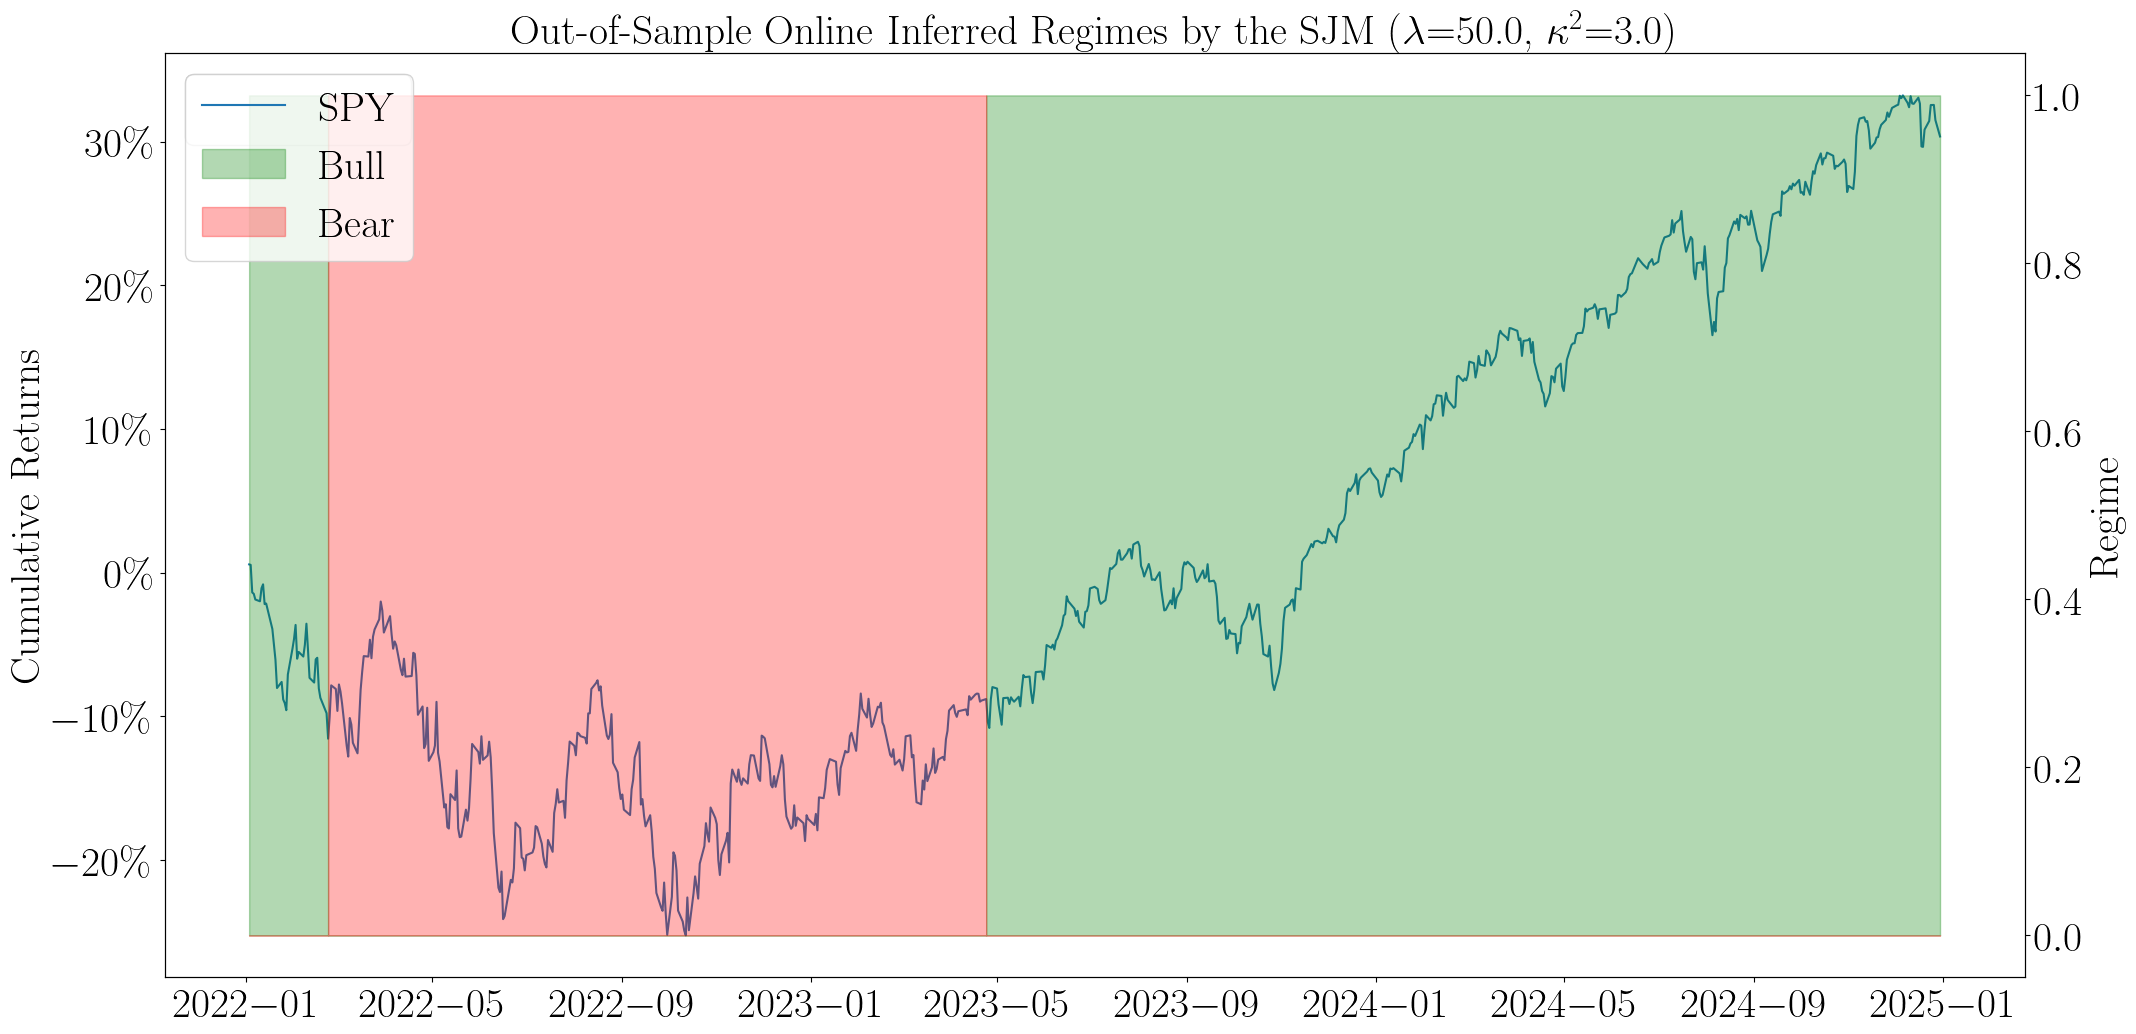

In [44]:
# online inference
labels_test_online_sjm = sjm.predict_online(X_test_processed)

# plot
ax, ax2 = plot_regimes_and_cumret(labels_test_online_sjm, data.ret_ser, start_date=test_start, end_date=test_end, )
ax.set(title=f"Out-of-Sample Online Inferred Regimes by the SJM ($\\lambda$={jump_penalty}, $\\kappa^2$={max_feats})")
savefig_plt(f"{get_curr_dir()}/plots/SJM_lambd-{jump_penalty}_max-feats-{max_feats}_test_online.pdf")

# Conclusion

This concludes the introduction to the functionalities of our `jumpmodels` library. 
The field of statistical jump models is still actively evolving, with ongoing research exploring new avenues.
We hope that the models and helper functions provided in this package will be useful in your own work. 
Citations and credits are always appreciated.

We welcome pull requests and open issues, and I’m happy to discuss any related questions.